# Homework - Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from typing import Union

## Getting the data
In this homework, the dataset Credit Card Data from book "Econometric Analysis" will be used.

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv")
data.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [3]:
data.describe()

,reports,age,income,share,expenditure,dependents,months,majorcards,active
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,0.456406,33.213103,3.365376,0.068732,185.057071,0.993935,55.267627,0.817286,6.996967
std,1.345267,10.142783,1.693902,0.094656,272.218917,1.247745,66.271746,0.386579,6.305812
min,0.000000,0.166667,0.210000,0.000109,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.416670,2.243750,0.002316,4.583333,0.000000,12.000000,1.000000,2.000000
50%,0.000000,31.250000,2.900000,0.038827,101.298300,1.000000,30.000000,1.000000,6.000000
75%,0.000000,39.416670,4.000000,0.093617,249.035800,2.000000,72.000000,1.000000,11.000000
max,14.000000,83.500000,13.500000,0.906320,3099.505000,6.000000,540.000000,1.000000,46.000000


## Preparing the data

In [4]:
data["card"].value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [5]:
data["card"] = data["card"].apply(lambda x: 1 if x == "yes" else 0)

df_full_train, df_test = train_test_split(data, test_size=.2, random_state=1)
df_train, df_valid= train_test_split(df_full_train, train_size=.75, random_state=1)

y_train = df_train["card"].values
y_valid = df_valid["card"].values
y_test = df_test["card"].values

## Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the `card` variable.
Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [6]:
def get_importances(X: pd.DataFrame, y: Union[pd.Series, list]) -> dict:
    """Calculates importance the importance of the numerical variables 
    against the target variable through calculation of the auc score.

    Args:
        df_train (pd.DataFrame): train dataset.
        y_true (Union[pd.Series, list]): target dataset.

    Returns:
        dict: dictionary containing the variables followed by their 
        respective scores.
    """
    only_numeric = X.select_dtypes(include=np.number)

    highest_score = 0
    highest_cat = ""

    d = {}

    for cat in only_numeric.columns:
        score = roc_auc_score(y, X[cat])
        if score < 0.5:
            score = roc_auc_score(y, -X[cat])
        d[cat] = score
    
    return d

get_importances(df_train.drop("card", axis=1), y_train)

{'reports': 0.7166629860689376,
 'age': 0.5240020979407055,
 'income': 0.5908049467233478,
 'share': 0.989183643423692,
 'expenditure': 0.991042345276873,
 'dependents': 0.5327757227773791,
 'months': 0.5294217780967629,
 'majorcards': 0.5343859842838476,
 'active': 0.6043173411362006}

## Training the model
From now on, use these columns only:

`["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]`

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

In [7]:
vectorizer = DictVectorizer(sparse=False)

In [8]:
X_train = df_train.drop("card", axis=1)

X_train = vectorizer.fit_transform(X_train.to_dict(orient="records"))
log_model = LogisticRegression(solver="liblinear", C=1, max_iter=1000)
log_model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

## Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)
- 0.615
- 0.515
- 0.715
- 0.995

In [9]:
X_valid = vectorizer.transform(df_valid.to_dict(orient="records"))
y_pred = log_model.predict_proba(X_valid)[:, 1]
round(roc_auc_score(y_valid, y_pred), 3)

0.995

## Question 3
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.1
- 0.3
- 0.6
- 0.8

In [10]:
def calculate_metrics_by_threshold(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculates precision and recall based on probability threshold

    Args:
        y_true (np.ndarray): true values
        y_pred (np.ndarray): predicted values

    Returns:
        DataFrame: A dataframe with the metrics
    """

    thresholds = np.linspace(0, 1, 101)

    actual_positive = (y_true == 1)
    actual_negative = (y_true == 0)

    precisions = []
    recalls = []
    f1scores = []

    for t in thresholds:
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * ((precision * recall) / (precision + recall))

        precisions.append(precision)
        recalls.append(recall)
        f1scores.append(f1)

    return pd.DataFrame({
        "thresholds": thresholds, 
        "precisions": precisions, 
        "recalls": recalls, 
        "f1scores": f1scores})

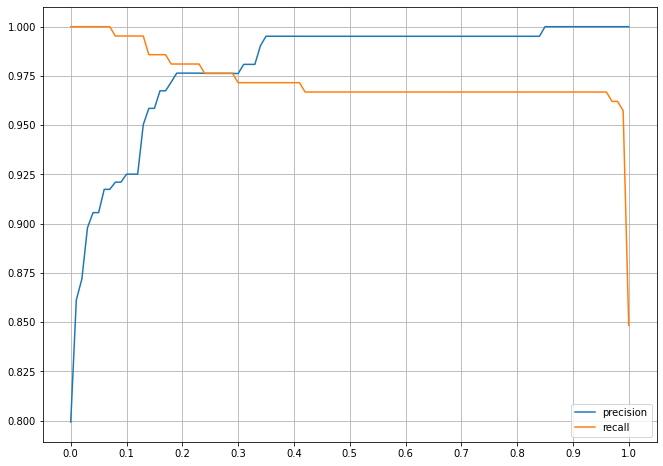

In [11]:
metrics = calculate_metrics_by_threshold(y_valid, y_pred)

plt.figure(figsize=(11, 8))
plt.plot(metrics.thresholds, metrics.precisions, label="precision")
plt.plot(metrics.thresholds, metrics.recalls, label="recall")
plt.xticks(np.linspace(0, 1, 11))
plt.legend()
plt.grid()
plt.show()

In [12]:
metrics[metrics["precisions"] == metrics["recalls"]]["thresholds"]

24    0.24
25    0.25
26    0.26
27    0.27
28    0.28
29    0.29
Name: thresholds, dtype: float64

## Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing :

$$
F_1=2\cdot \frac{P\cdot R}{(P+R)}
$$

Where  is precision and  is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

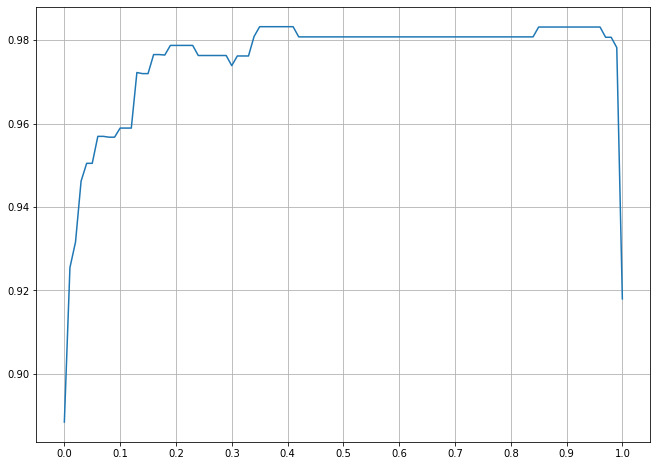

In [13]:
plt.figure(figsize=(11, 8))
plt.plot(metrics.thresholds, metrics.f1scores)
plt.xticks(np.linspace(0, 1, 11))
plt.grid()
plt.show()

In [14]:
maxf1 = metrics["f1scores"].max()
metrics[metrics.f1scores == maxf1]["thresholds"]

35    0.35
36    0.36
37    0.37
38    0.38
39    0.39
40    0.40
41    0.41
Name: thresholds, dtype: float64

## Question 5
Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

- Iterate over different folds of `df_full_train`
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [15]:
def train(X_train: pd.DataFrame, y_train: pd.DataFrame, C=1):
    """Executes the training of the model.

    Args:
        X_train (pd.DataFrame): features dataset.
        y_train (pd.DataFrame): target dataset.
        C (int, optional): regularization force level that will be applied
        to the model. Defaults to 1.

    Returns:
        (DictVectorizer, LogisticRegression): a fitted vectorizer that will
        one_hot encode the categorical features and a trained logistic 
        regression model.
    """
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(X_train.drop("card", axis=1).to_dict(orient="records"))
    
    model = LogisticRegression(C=C, solver="liblinear", max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

In [16]:
def predict(X_test: pd.DataFrame, vectorizer: DictVectorizer, model: LogisticRegression):
    """Executes the prediction of the model.

    Args:
        X_test (pd.DataFrame): features dataset.
        vectorizer (DictVectorizer): vectorizer that will one-hot encode
        the categorical variables.
        model (LogisticRegression): trained logistic regression model.

    Returns:
        pd.ndarray: probabilites for each predicted class of the model.
    """
    X = vectorizer.transform(X_test.to_dict(orient="records"))
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [17]:
def kfold_train(kfold: KFold, data: pd.DataFrame, C=1):
    """Applies KFold cross validation to the training.

    Args:
        kfold (KFold): KFold instance.
        data (pd.DataFrame): training dataset.
        C (int, optional): regularization force level that will be applied
        to the model. Defaults to 1.

    Returns:
        _type_: ROC AUC scores obtained after cross validation.
    """
    scores = []
    for train_indexes, valid_indexes in kfold.split(data):
        df_train = data.iloc[train_indexes]
        df_valid = data.iloc[valid_indexes]

        y_train = df_train["card"].values
        y_valid = df_valid["card"].values

        vectorizer, model = train(df_train, y_train, C)

        y_pred = predict(df_valid, vectorizer, model)

        score = roc_auc_score(y_valid, y_pred)
        scores.append(score)
    return scores


kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = kfold_train(kfold, df_full_train)
    
np.std(scores)

0.0027434713804377724

## Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: `[0.01, 0.1, 1, 10]`
- Initialize `KFold` with the same parameters as previously
- Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

In [18]:
C = [0.01, 0.1, 1, 10]
kfold = KFold(shuffle=True, random_state=1)

c_scores = {}
for c_value in C:
    scores = kfold_train(kfold, df_full_train, c_value)
    c_scores[c_value] = {"mean": np.mean(scores), "std deviation": np.std(scores)}

for c in c_scores.keys(): print(f"C = {c}: {c_scores[c]}")

C = 0.01: {'mean': 0.9918810292344007, 'std deviation': 0.00559887235402738}
C = 0.1: {'mean': 0.9950557137157224, 'std deviation': 0.003954138088244392}
C = 1: {'mean': 0.9964498276814243, 'std deviation': 0.0027434713804377724}
C = 10: {'mean': 0.9963886109436032, 'std deviation': 0.0028151486609295684}
